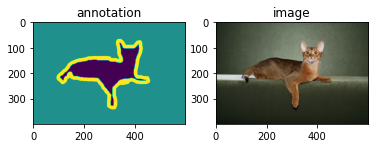

In [1]:
import matplotlib.pyplot as plt

from PIL import Image

path_to_annotation = "annotations/trimaps/"
path_to_image = "images/"

annotation = Image.open(path_to_annotation + "Abyssinian_1.png")
plt.subplot(1, 2, 1)
plt.title("annotation")
plt.imshow(annotation)

image = Image.open(path_to_image + "Abyssinian_1.jpg")
plt.subplot(1, 2, 2)
plt.title("image")
plt.imshow(image)

plt.show()

In [2]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset
from PIL import Image


class Pets(Dataset):
   def __init__(self, path_to_img, 
                path_to_anno, 
                train=True, 
                transforms=None, 
                input_size=(128, 128)):

       self.images = sorted(glob.glob(path_to_img+"/*.jpg"))
       self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))


       self.X_train = self.images[:int(0.8 * len(self.images))]
       self.X_test = self.images[int(0.8 * len(self.images)):]
       self.Y_train = self.annotations[
                :int(0.8 * len(self.annotations))]
       self.Y_test = self.annotations[
                int(0.8 * len(self.annotations)):]

       self.train = train
       self.transforms = transforms
       self.input_size = input_size
   def __len__(self):
       if self.train:
           return len(self.X_train)
       else:
           return len(self.X_test)
   def preprocess_mask(self, mask):
       mask = mask.resize(self.input_size)
       mask = np.array(mask).astype(np.float32) 
       mask[mask != 2.0] = 1.0 
       mask[mask == 2.0] = 0.0 
       mask = torch.tensor(mask)  
       return mask
   def __getitem__(self, i):
       if self.train:
           X_train = Image.open(self.X_train[i])
           X_train = self.transforms(X_train)
           Y_train = Image.open(self.Y_train[i])
           Y_train = self.preprocess_mask(Y_train)

           return X_train, Y_train
       else:
           X_test = Image.open(self.X_test[i])
           X_test = self.transforms(X_test)
           Y_test = Image.open(self.Y_test[i])
           Y_test = self.preprocess_mask(Y_test)

           return X_test, Y_test

/home/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch.nn as nn


class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()
       self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
       self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
       self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
       self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
       self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
       self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

       self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
       self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
       self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

       self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
       self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
       self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

       self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
       self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
       self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

       self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
       self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
       self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

       self.relu = nn.ReLU()
       self.sigmoid = nn.Sigmoid()
       
   def forward(self, x):
       x = self.enc1_1(x)
       x = self.relu(x)
       e1 = self.enc1_2(x)
       e1 = self.relu(e1)
       x = self.pool1(e1)

       x = self.enc2_1(x)
       x = self.relu(x)
       e2 = self.enc2_2(x)
       e2 = self.relu(e2)
       x = self.pool2(e2)

       x = self.enc3_1(x)
       x = self.relu(x)
       e3 = self.enc3_2(x)
       e3 = self.relu(e3)
       x = self.pool3(e3)

       x = self.enc4_1(x)
       x = self.relu(x)
       e4 = self.enc4_2(x)
       e4 = self.relu(e4)
       x = self.pool4(e4)

       x = self.enc5_1(x)
       x = self.relu(x)
       x = self.enc5_2(x)
       x = self.relu(x)
       x = self.upsample4(x)

       x = torch.cat([x, e4], dim=1)
       x = self.dec4_1(x)
       x = self.relu(x)
       x = self.dec4_2(x)
       x = self.relu(x)

       x = self.upsample3(x)
       x = torch.cat([x, e3], dim=1)
       x = self.dec3_1(x)
       x = self.relu(x)
       x = self.dec3_2(x)
       x = self.relu(x)

       x = self.upsample2(x)
       x = torch.cat([x, e2], dim=1)
       x = self.dec2_1(x)
       x = self.relu(x)
       x = self.dec2_2(x)
       x = self.relu(x)

       x = self.upsample1(x)
       x = torch.cat([x, e1], dim=1)
       x = self.dec1_1(x)
       x = self.relu(x)
       x = self.dec1_2(x)
       x = self.relu(x)
       x = self.dec1_3(x)

       x = torch.squeeze(x)

       return x

In [4]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = Compose([
   Resize((128, 128)),
   ToTensor()
])

In [5]:
train_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform)

test_set = Pets(path_to_img=path_to_image,
                path_to_anno=path_to_annotation, 
                transforms=transform, 
                train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

In [6]:
model = UNet().to(device)

learning_rate = 0.0001

optim = Adam(params=model.parameters(), lr=learning_rate)

In [7]:
for epoch in range(200):
   iterator = tqdm.tqdm(train_loader)

   for data, label in iterator:
       optim.zero_grad()

       preds = model(data.to(device))
       loss = nn.BCEWithLogitsLoss()(
           preds, 
           label.type(torch.FloatTensor).to(device))
       loss.backward()

       optim.step()

       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./UNet.pth")

  0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
epoch100 loss:0.0365426167845726:  32%|███▏      | 59/185 [00:24<00:51,  2.44it/s]  


KeyboardInterrupt: 

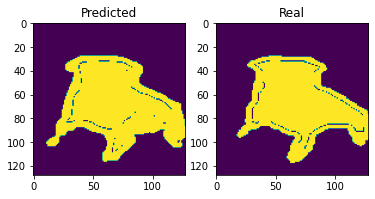

In [11]:
model.load_state_dict(torch.load("./UNet.pth", map_location="cpu"))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0)).cpu()>0.5

with torch.no_grad():
    plt.subplot(1, 2, 1)
    plt.title("Predicted")
    plt.imshow(pred)
    plt.subplot(1, 2, 2)
    plt.title("Real")
    plt.imshow(label)
    plt.show()